# Goal: better peak finding

Method: use multiple methods to find candidate peaks, then cluster them to find a "real" peak

In [1]:
from wbfm.utils.projects.finished_project_data import finished_project_data
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import ndimage as ndi

import napari, zarr
from skimage.transform import PiecewiseAffineTransform, warp
from scipy.spatial import KDTree
from skimage.feature import peak_local_max, blob_dog

In [2]:
fname = "/project/neurobiology/zimmer/wbfm/dlc_stacks_updated/Charlie-worm3-new-seg/project_config.yaml"
dat_worm3 = finished_project_data.load_final_project_data_from_config(fname)

# fname = "/project/neurobiology/zimmer/wbfm/dlc_stacks_updated/Charlie-worm3-new-seg/project_config.yaml"
# dat_gfp = finished_project_data.load_final_project_data_from_config(fname)

In [3]:
fname = "/project/neurobiology/zimmer/wbfm/dat/ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051-channel-0-pco_camera1/2021-03-04_16-07-57_worm3_ZIM2051-channel-0-pco_camera1bigtiff.zarr"
dat_red = zarr.open(fname)
dat_red.shape

fname = "/project/neurobiology/zimmer/wbfm/dat/ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051/2021-03-04_16-07-57_worm3_ZIM2051-channel-1-pco_camera2/2021-03-04_16-07-57_worm3_ZIM2051-channel-1-pco_camera2bigtiff.zarr"
dat_green = zarr.open(fname)
dat_green.shape

(1500, 32, 700, 900)

# Get a volume and test peaks

In [11]:
i_frame = 1

vol = np.array(dat_red[i_frame, 1:, ...])

mask = np.array(dat_worm3.raw_segmentation[i_frame, 1:,...])
# mask = mask>0

vol.shape

(31, 700, 900)

In [12]:
# First: basic peaks
p1 = peak_local_max(vol.copy(), labels=mask, min_distance=5)
p2 = peak_local_max(ndi.gaussian_filter(vol, sigma=2), labels=mask, min_distance=5)
p3 = peak_local_max(ndi.gaussian_filter(vol, sigma=3), labels=mask, min_distance=5)


In [13]:
# Second: difference of gaussian
diff_of_gaussian = blob_dog(vol.astype('float'), min_sigma=1, max_sigma=10, threshold=15, exclude_border=1)


# OLD:
# p2 = corner_peaks(vol, labels=mask, min_distance=5)

In [14]:
print(len(diff_of_gaussian))

87


In [15]:
v = napari.view_image(vol, ndisplay=3)

v.add_points(p1, size=3)
v.add_points(p2, size=3, face_color='blue')
v.add_points(p3, size=3, face_color='green')
v.add_points(diff_of_gaussian[:,[0,1,2]], size=3, face_color='red')

v.add_labels(mask, visible=False)

<Labels layer 'mask' at 0x7f590836d8d0>

# Redo stardist segmentation with different parameters

In [4]:
from segmentation.util.utils_model import get_stardist_model
from segmentation.util.utils_pipeline import segment_video_using_config_2d
from segmentation.util.utils_postprocessing import remove_dim_slices
from segmentation.util.utils_pipeline import perform_post_processing_2d
from csbdeep.utils import Path, normalize

from stardist.geometry import _dist_to_coord_old as dist_to_coord
from stardist.nms import _non_maximum_suppression_old as non_maximum_suppression
from stardist.geometry import _polygons_to_label_old as polygons_to_label
from skimage.transform import resize
import skimage
import scipy
from collections import defaultdict
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import clear_border, find_boundaries

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [5]:
def segment_with_stardist_full(vol, model):
    # See: segment_with_stardist_2d
    # initialize output dimensions and other variables
    z = len(vol)
    xy = vol.shape[1:]
    segmented_masks = np.zeros_like(vol)    # '*' = tuple unpacking
    boundary = np.zeros_like(segmented_masks, dtype='bool')
    axis_norm = (0, 1)
    n_channel = 1

    # iterate over images to run stardist on single images
    for idx, plane in enumerate(vol):
        img = plane

        # normalizing images (stardist function)
        img = normalize(img, 1, 99.8, axis=axis_norm)

        # run the prediction
        labels, details = model.predict_instances(img)
        
        # Remove border-touching elements (almost certainly rotation artifacts)
        labels = clear_border(labels, buffer_size=20)
        
        # Postprocess to add separation between labels
        # From: watershed.py in 3DeeCellTracker
        labels_bd = find_boundaries(labels, connectivity=1, mode='outer', background=0)

        boundary[idx, :, :] = labels_bd

        # save labels in 3D array for output
        segmented_masks[idx] = labels

    segmented_masks[boundary==1] = 0
    
    remove_dim_slices(segmented_masks, vol)
    
    return segmented_masks

In [6]:
i_frame = 1
vol_red = np.array(dat_red[i_frame, 1:, ...])
vol_green = np.array(dat_green[i_frame, 1:, ...])

In [7]:
stardist_model_name = 'lukas'
sd_model = get_stardist_model(stardist_model_name)

segmented_masks = segment_with_stardist_full(vol_red, sd_model)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.458531, nms_thresh=0.4.


In [15]:
# Additional custom postprocessing

# Remove dim pixels
threshold = 15
dim_pixels = vol_red < threshold
segmented_masks[dim_pixels] = 0

# Mainline postprocessing
opt_postprocessing = {'border_width_to_remove':5,
                     'to_remove_dim_slices':True,
                     'stitch_via_watershed':False,
                     'upper_length_threshold':12,
                     'DEBUG':True} # Basically don't split long neurons at all

final_masks = perform_post_processing_2d(segmented_masks,
                                             vol_red,
                                             **opt_postprocessing,
                                             verbose=1)

Starting preprocessing with 104 neurons
Note: not yet stitched in z
Removing large areas in all planes
After large area removal: 104
Bipartite stitching. Input array shape: (31, 700, 900)
After stitching: 164
After splitting: 190
After short neuron removal: 172
After border removal: 173
Postprocessing finished
Saving workspace at: stardist_2d_postprocessing.out


In [16]:
v = napari.view_image(vol_red, ndisplay=3)

v.add_labels(final_masks)

<Labels layer 'final_masks' at 0x7fba9c464bd0>

ERROR - 2021-09-29 14:16:00,539 - zmqstream - Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 526, in _check_runnung
    'Cannot run the event loop while another loop is running')
RuntimeError: Cannot run the event loop while another loop is running


In [17]:
opt = {'min_distance': 7,
       'num_peaks_per_label': 2,
       'labels':final_masks,
       'threshold_abs': 20}#, 
       #'footprint': np.ones((5, 11, 11))}

# Find peaks within the columns

# Gaussian blurring
p1_red = peak_local_max(vol_red.copy(), **opt)
vol_red_blur2 = ndi.gaussian_filter(vol_red, sigma=2)
p2_red = peak_local_max(vol_red_blur2, **opt)
vol_red_blur3 = ndi.gaussian_filter(vol_red, sigma=3)
p3_red = peak_local_max(vol_red_blur3, **opt)

# Only filter in 2d
p122_red = peak_local_max(ndi.gaussian_filter(vol_red, sigma=[1,2,2]), **opt)
p133_red = peak_local_max(ndi.gaussian_filter(vol_red, sigma=[1,3,3]), **opt)

# Peaks on green channel
p1_green = peak_local_max(vol_green.copy(), **opt)
p2_green = peak_local_max(ndi.gaussian_filter(vol_green, sigma=2), **opt)
p3_green = peak_local_max(ndi.gaussian_filter(vol_green, sigma=3), **opt)

# Peaks on distance transform
distance = ndi.distance_transform_edt(final_masks)

distance_times_brightness1 = np.multiply(distance, ndi.gaussian_filter(vol_red, sigma=1))
p1_red_dist = peak_local_max(distance_times_brightness1, **opt)
distance_times_brightness2 = np.multiply(distance, vol_red_blur2)
p2_red_dist = peak_local_max(distance_times_brightness2, **opt)
distance_times_brightness3 = np.multiply(distance, vol_red_blur3)
p3_red_dist = peak_local_max(distance_times_brightness3, **opt)

ERROR - 2021-09-29 14:16:00,549 - zmqstream - Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 448, in _handle_events
    self._handle_recv()
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 477, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/site-packages/jupyter_client/threaded.py", line 121, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/charles/anaconda3/envs/segmentation/lib/python3.7/asyncio/base_events.py", line 563, in run_until_complete
    self._check_runnung()
  File "/home/cha

In [309]:
v = napari.view_image(vol_red, ndisplay=3)
v.add_image(vol_green)

v.add_points(p1_red, face_color='red', size=1)
v.add_points(p2_red, face_color='red', size=2)
v.add_points(p3_red, face_color='red', size=3)
v.add_points(p122_red, face_color='magenta', size=2)
v.add_points(p133_red, face_color='magenta', size=3)
v.add_points(p1_red_dist, face_color='grey', size=1)
v.add_points(p2_red_dist, face_color='grey', size=2)
v.add_points(p3_red_dist, face_color='grey', size=3)
v.add_points(p1_green, face_color='green', size=1)
v.add_points(p2_green, face_color='green', size=2)
v.add_points(p3_green, face_color='green', size=3)
v.add_labels(final_masks, visible=False)

<Labels layer 'final_masks' at 0x7fad183d3550>

In [310]:
def remove_vals_below_min_len(dict_to_mutate, min_len=2):
    keys = list(dict_to_mutate.keys())
    for k in keys:
        if len(dict_to_mutate[k]) < min_len:
            dict_to_mutate.pop(k)
    return dict_to_mutate

# Cluster peaks and segment using watershed
peaks_to_check = [p1_red, p2_red, p3_red, p122_red, p133_red, p1_red_dist, p2_red_dist, p3_red_dist]

# Get the original column labels for each peak
raw_labels_per_method = {}
for i, peak_list in enumerate(peaks_to_check):
    raw_labels_per_method[i] = [final_masks[p[0], p[1], p[2]] for p in peak_list]
    
# Reverse the dict to be label => zxy indices
label2zxy_per_method = {}
for i, peak_list in enumerate(peaks_to_check):
    label2zxy = defaultdict(list)
    for label, peak in zip(raw_labels_per_method[i], peak_list):
        label2zxy[label].append(peak)
        
    # And remove ones of length one
    label2zxy = remove_vals_below_min_len(label2zxy, min_len=2)
            
    label2zxy_per_method[i] = label2zxy

# If at least 2 algorithms found >1 peak, try to split
# 1. Make 2 clusters of the found peaks
# 2. Watershed (on the original image... blurred?)

label2zxy_total = defaultdict(list)
for method, label2zxy in label2zxy_per_method.items():
    for label, zxy in label2zxy.items():
        label2zxy_total[label].append(zxy)
label2zxy_total = remove_vals_below_min_len(label2zxy_total, min_len=3)

In [311]:
label2zxy_total

defaultdict(list,
            {27: [[array([  8, 221, 299]), array([ 19, 214, 293])],
              [array([  8, 221, 298]), array([ 20, 214, 292])],
              [array([  8, 221, 298]), array([ 20, 214, 291])],
              [array([  9, 221, 298]), array([ 22, 215, 291])],
              [array([  9, 221, 298]), array([ 22, 215, 291])]],
             28: [[array([  7, 182, 229]), array([ 18, 198, 221])],
              [array([  8, 184, 228]), array([ 19, 199, 218])],
              [array([  8, 184, 228]), array([ 20, 200, 215])],
              [array([  8, 184, 228]), array([ 19, 200, 218])],
              [array([  8, 184, 228]), array([ 19, 199, 216])],
              [array([  9, 185, 229]), array([ 20, 201, 218])],
              [array([  9, 185, 229]), array([ 21, 205, 219])],
              [array([  9, 185, 229]), array([ 21, 205, 219])]],
             39: [[array([ 17, 184, 175]), array([  8, 173, 188])],
              [array([  9, 174, 187]), array([ 16, 183, 176])],
        

In [288]:
label2zxy_total

defaultdict(list,
            {27: [[array([  8, 221, 299]), array([ 19, 214, 293])],
              [array([  8, 221, 298]), array([ 20, 214, 292])],
              [array([  8, 221, 298]), array([ 20, 214, 291])]],
             28: [[array([  7, 182, 229]), array([ 18, 198, 221])],
              [array([  8, 184, 228]), array([ 19, 199, 218])],
              [array([  8, 184, 228]), array([ 20, 200, 215])],
              [array([  8, 184, 228]), array([ 19, 200, 218])],
              [array([  8, 184, 228]), array([ 19, 199, 216])]],
             39: [[array([ 17, 184, 175]), array([  8, 173, 188])],
              [array([  9, 174, 187]), array([ 16, 183, 176])],
              [array([  8, 173, 187]), array([ 17, 184, 175])],
              [array([  8, 172, 187]), array([ 17, 183, 175])]],
             43: [[array([  8, 243, 266]), array([ 19, 253, 266])],
              [array([  9, 244, 266]), array([ 19, 251, 265])],
              [array([  9, 243, 267]), array([ 20, 253, 268])],
   

# Look at the workspace variables that would be used for splitting

In [10]:
import shelve
from ipywidgets import interact
import matplotlib.pyplot as plt
from segmentation.util.utils_postprocessing import calc_split_point_via_brightnesses
from scipy.signal import find_peaks


In [13]:
workspace_fname = 'stardist_2d_postprocessing.out'
ws = shelve.open(workspace_fname)

In [14]:
brightnesses = ws['brightnesses']
# %matplotlib inline

def f(key, to_split=False):
    b = brightnesses[key]
    
    if to_split:
        means, _, _ = calc_split_point_via_brightnesses(b, plots=1)
    
        inter_peak_brightnesses = np.array(b[means[0]+1:means[1]])
        split_point, _ = find_peaks(-inter_peak_brightnesses)
        split_point = split_point[0]
        split_point += means[0] + 1
        print(f"Split point: {split_point}")
    else:
        plt.plot(b)
    
    print("Initial peak guess")
    print(find_peaks(b, distance=4))

interact(f, key=list(brightnesses.keys()))

interactive(children=(Dropdown(description='key', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, …

<function __main__.f(key, to_split=False)>

In [21]:
b = brightnesses[42]


find_peaks(b, distance=4)

(array([ 6, 17]), {})

In [7]:
%debug

> /home/charles/Current_work/repos/segmentation/segmentation/util/utils_postprocessing.py(418)calc_means_via_brightnesses()
    416     if len(peaks) == 2:
    417         peak0, peak1 = peaks
--> 418     p0 = [np.mean(y_data), peak0, sigma, np.mean(y_data), peak1, sigma]
    419 
    420     try:



ipdb>  peaks


array([], dtype=int64)


ipdb>  len(y_data)


5


ipdb>  q


# SCRATCH

https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py

In [40]:

from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial

In [86]:
i_frame = 1

vol = np.array(dat[i_frame, 1:, ...])

binary_neurons = np.array(dat_worm3.raw_segmentation[i_frame, 1:,...])
binary_neurons = (binary_neurons>0).astype(int)

# Remove dim pixels from training data
threshold = 25
dim_pixels = vol < threshold
binary_neurons[dim_pixels] = 0

In [91]:
# Dummy training to see if this works at all
threshold = 25
binary_neurons = (vol > threshold).astype(int)

In [105]:

sigma_min = 1
sigma_max = 10
features_func = partial(feature.multiscale_basic_features,
                        intensity=True, edges=False, texture=False,
                        sigma_min=sigma_min, sigma_max=sigma_max,
                        multichannel=True)

In [108]:
features = features_func(np.expand_dims(vol, axis=-1))

In [109]:
i_slice = 15

clf = RandomForestClassifier(n_estimators=50, n_jobs=None,
                             max_depth=10, class_weight="balanced")

clf = future.fit_segmenter(binary_neurons[i_slice,...], features[i_slice,...], clf)
result = future.predict_segmenter(features[i_slice,...], clf)

In [110]:
v = napari.view_image(vol[i_slice,...])
v.add_labels(binary_neurons[i_slice,...])
v.add_labels(result)

<Labels layer 'result' at 0x7fb667a84d90>

In [64]:
v = napari.view_image(vol, ndisplay=3)
v.add_labels(binary_neurons)
v.add_labels(result)

<Labels layer 'result' at 0x7fb6d2599cd0>

In [80]:
# import matplotlib.pyplot as plt

# %matplotlib inline
# plt.figure(figsize=(45,25))
# plt.imshow(segmentation.mark_boundaries(vol[i_slice,...], result, mode='thick'))

# Scratch: basic thresholding

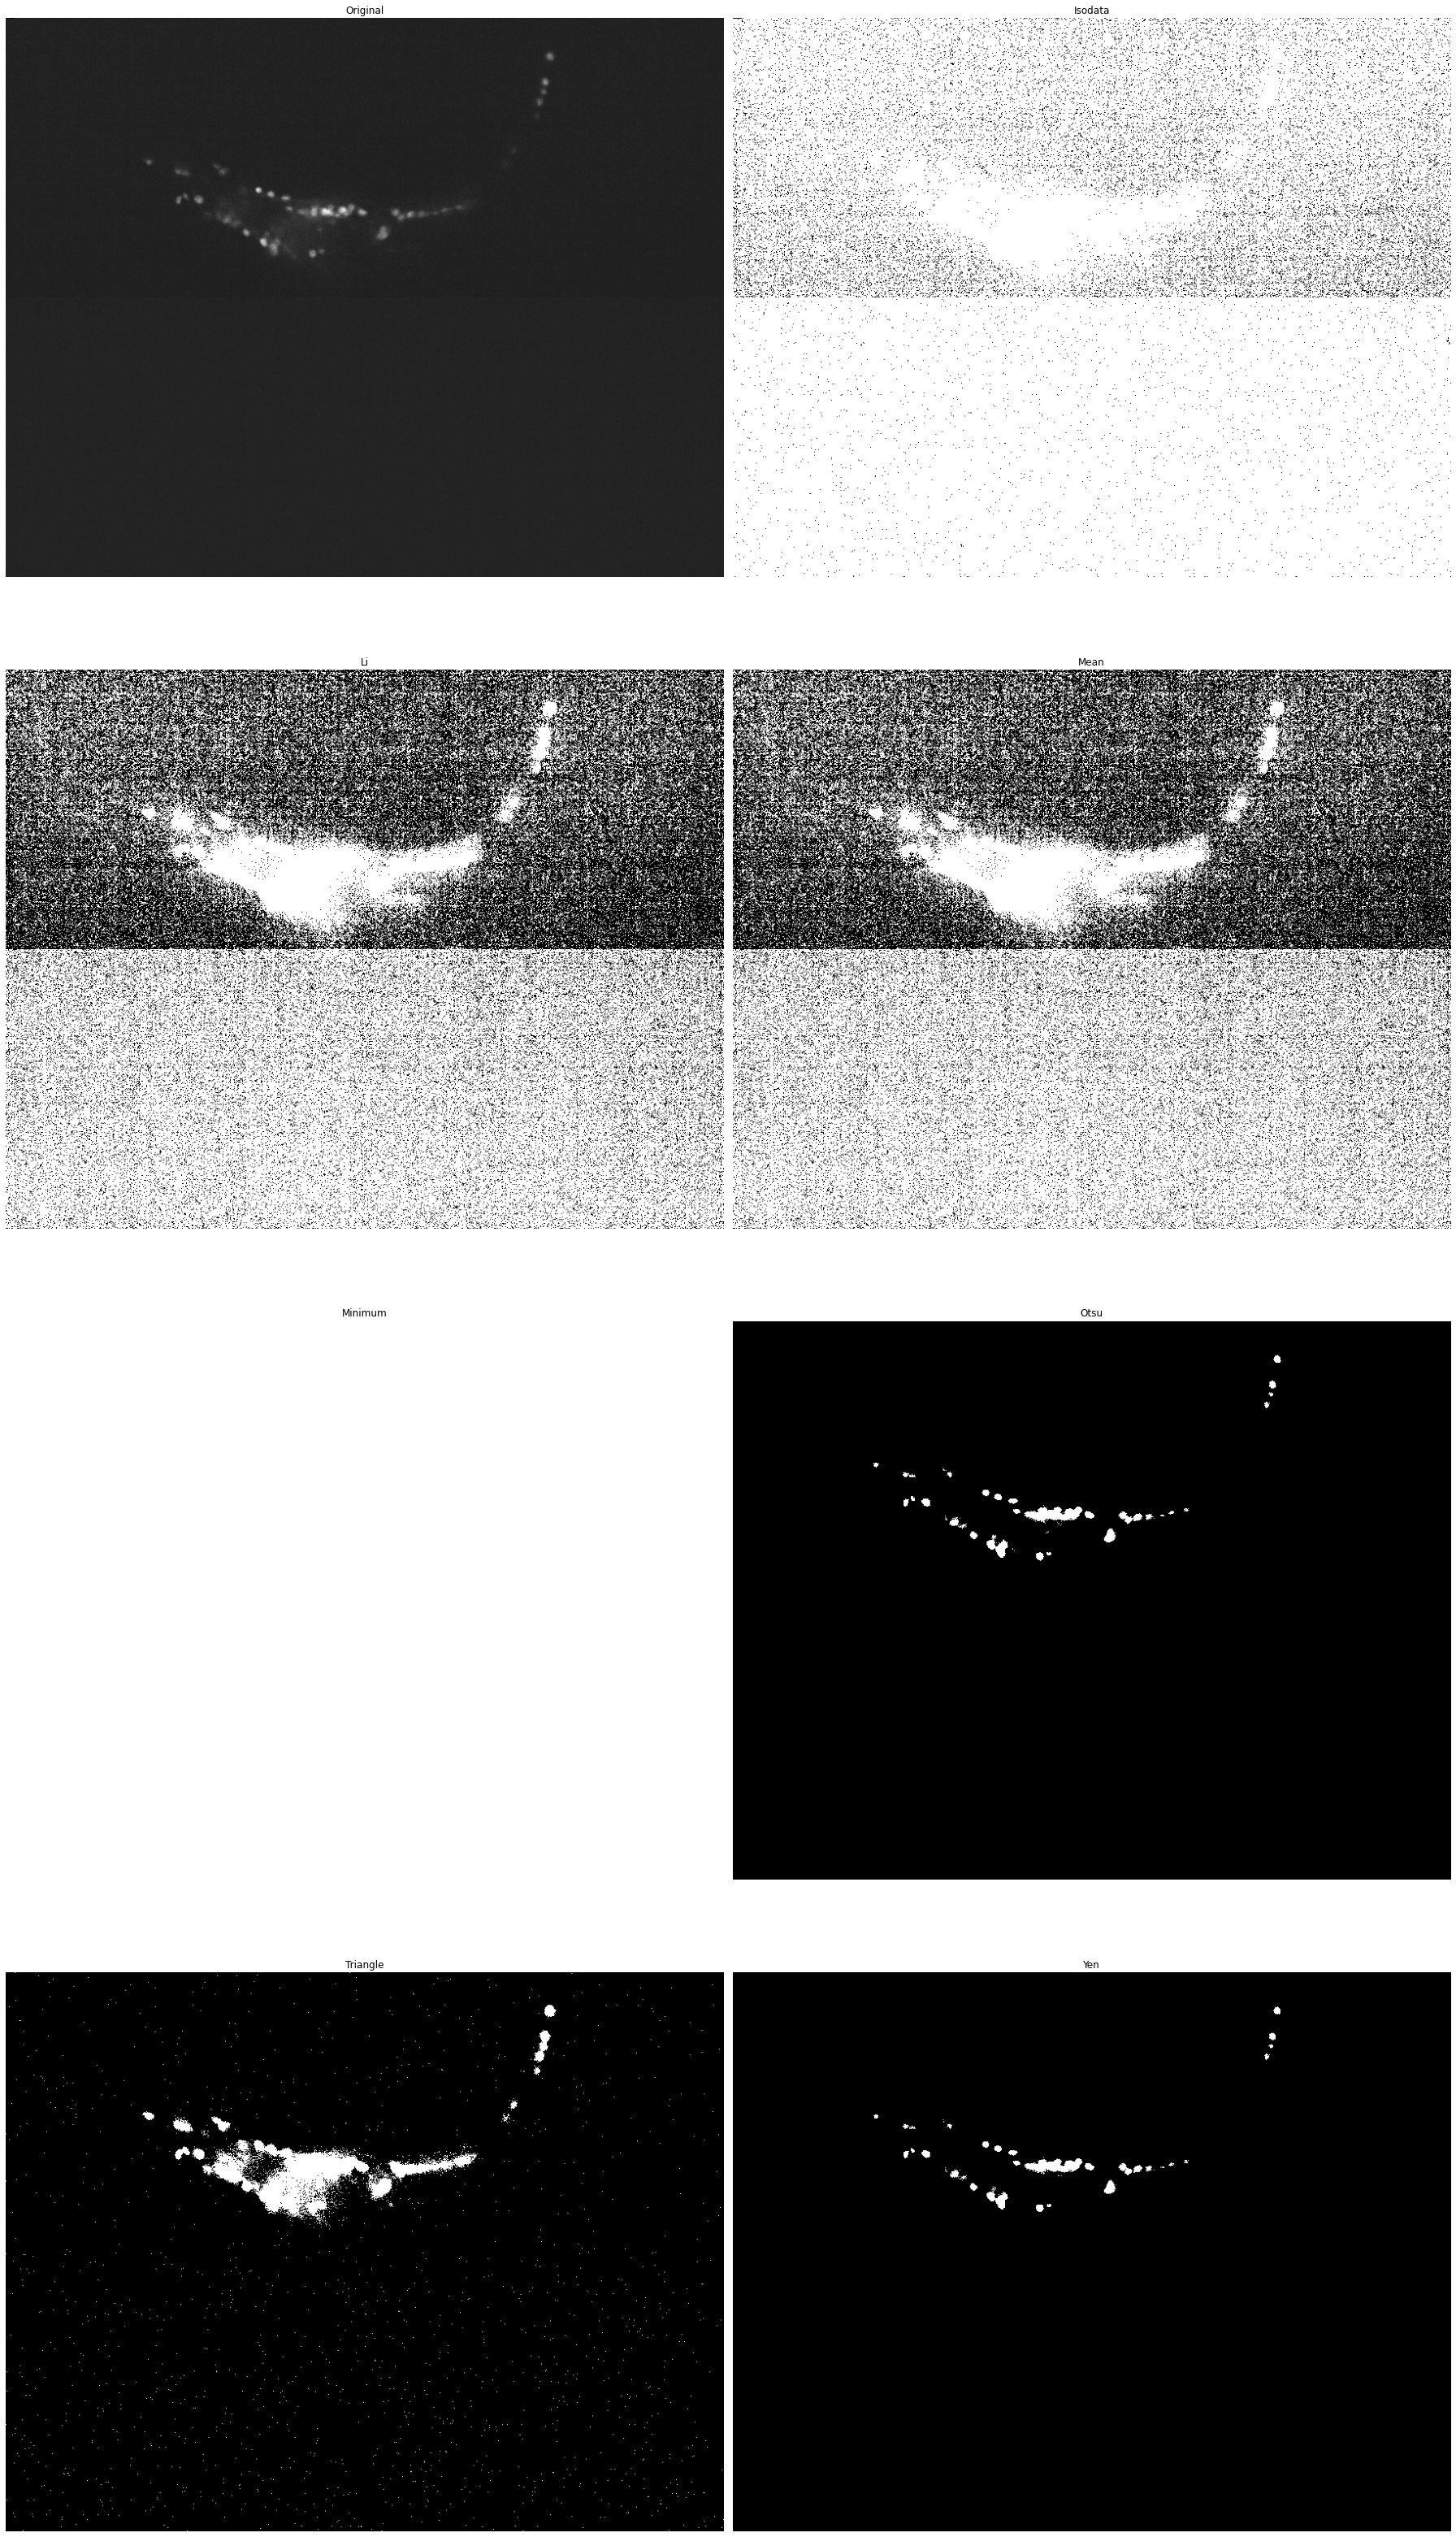

In [111]:
from skimage.filters import try_all_threshold

img = vol[i_slice, ...]

%matplotlib inline
fig, ax = try_all_threshold(img, figsize=(25, 45), verbose=False)
plt.show()